This file contains the model architecture that combines BERT and tags to then predict the labels. In this case we work with only 2 dimensions (batch size and features) insetad of 3 dimensions (i.e. including sequence length). We do not use a GCN yet.

In [42]:
# choose dataset from 'NPOV', 'WNC', 'CrowS-Pairs', 'Stereo', 'Mixed'
dataset = 'Mixed'

# Setting Up

In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 12.3 MB/s 
     |████████████████████████████████| 120 kB 55.6 MB/s 
     |████████████████████████████████| 6.6 MB 51.9 MB/s 


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import seaborn as sns
import shutil
import nltk
import sys
import matplotlib.pyplot as plt
from string import punctuation
from transformers import BertTokenizerFast, BertModel 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import nltk
from nltk.parse.stanford import StanfordDependencyParser

import sys; sys.path.append('.')

import spacy
nlp = spacy.load("en_core_web_sm")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Model Checkpoint

In [6]:
# Save and Load Functions

def save_checkpoint(save_path, model, optimizer, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_checkpoint(load_path, model, optimizer):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    
    return state_dict['valid_loss']

# Tags

In [7]:
# Dependency parser: https://spacy.io/api/dependencyparser
# https://www.upgrad.com/blog/dependency-parsing-in-nlp/ 
RELATIONS = ['<PAD>',
    'ROOT', 'acl', 'acomp', 'advcl', 'advmod', 'agent', 'amod', 'appos', 
    'aux', 'auxpass', 'case', 'cc', 'ccomp', 'compound', 'conj', 'csubj', 
    'dative', 'dep', 'det', 'dobj', 'expl', 'intj', 'mark', 'meta', 'neg',
    'nmod', 'npadvmod', 'nsubj', 'nsubjpass', 'nummod', 'oprd', 'parataxis',
    'pcomp', 'pobj', 'poss', 'preconj', 'predet', 'prep', 'prt', 'punct',
    'quantmod', 'relcl', 'xcomp', 'attr', 'csubjpass',
    '<UNK>'
]
REL2ID = {x: i for i, x in enumerate(RELATIONS)}

# Part-Of-Speech tagging: https://spacy.io/usage/linguistic-features#pos-tagging 
POS_TAGS = ['<PAD>',
    'ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'CONJ', 'DET', 'EOL',
    'IDS', 'INTJ', 'NAMES', 'NOUN', 'NO_TAG', 'NUM', 'PART',
    'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SPACE', 'SYM', 'VERB', 'X',
    '<UNK>'
]
POS2ID = {x: i for i, x in enumerate(POS_TAGS)} 

# Data

In [43]:
# import datasets
source_folder = "/content/drive/MyDrive/Colab Notebooks/Amplifi Project/Data/Processed Datasets/"
train_df = pd.read_csv(source_folder + dataset + '_train.csv', delimiter=',')
val_df = pd.read_csv(source_folder + dataset + '_valid.csv', delimiter=',')
test_df = pd.read_csv(source_folder + dataset + '_test.csv', delimiter=',')

In [44]:
# hyperparameters
max_len = 200 # we cap the max length at 200, even though some data samples have larger length
train_batch_size = 16
val_batch_size = 16
test_batch_size = 16

target_list = ['label']

In [45]:
class CustomDataset(torch.utils.data.Dataset):

    def __init__(self, df, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.df = df
        self.title = df['text']
        self.pos = df['pos_tags']
        self.rel = df['rel_tags']
        self.targets = self.df[target_list].values
        self.max_len = max_len

    def __len__(self):
        return len(self.title)

    def __getitem__(self, index):
        title = str(self.title[index])
        title = " ".join(title.split())

        pos_str = str(self.pos[index])
        pos = []
        for tag in pos_str.split():
          try:
            pos.append(POS2ID[tag])
          except:
            POS2ID['<UNK>']
        pos = torch.tensor(pos)
        pos_ids = torch.zeros(max_len, dtype=int)
        if len(pos) > max_len:
          pos_ids[:] = pos[:max_len]
        else:
          pos_ids[:len(pos)] = pos
          # pos_ids[(max_len - len(pos)):] = pos

        rel_str = str(self.rel[index])
        rel = []
        for tag in rel_str.split():
          try:
            rel.append(REL2ID[tag])
          except:
            REL2ID['<UNK>']
        rel = torch.tensor(rel)
        rel_ids = torch.zeros(max_len, dtype=int)
        if len(rel) > max_len:
          rel_ids[:] = rel[:max_len]
        else:
          rel_ids[:len(rel)] = rel
          # rel_ids[(max_len - len(rel)):] = rel

        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=False, # we do not want SOS and EOS tokens
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=False, # we cannot have this if we do not have SOS and EOS tokens
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'text': title,
            'input_ids': inputs['input_ids'].flatten(), # ID of each token in the text
            'pos_ids': pos_ids,
            'rel_ids': rel_ids,
            'attention_mask': inputs['attention_mask'].flatten(),
            # 'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.FloatTensor(self.targets[index]) # Bias and Unbias label (0 when False, 1 when True)
        }

In [46]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [47]:
train_dataset = CustomDataset(train_df, tokenizer, max_len)
val_dataset = CustomDataset(val_df, tokenizer, max_len)
test_dataset = CustomDataset(test_df, tokenizer, max_len)

In [48]:
train_loader = torch.utils.data.DataLoader(train_dataset, 
    batch_size=train_batch_size,
    shuffle=True,
    num_workers=0
)

val_loader = torch.utils.data.DataLoader(val_dataset, 
    batch_size=val_batch_size,
    shuffle=False,
    num_workers=0
)

test_loader = torch.utils.data.DataLoader(test_dataset, 
    batch_size=test_batch_size,
    shuffle=False,
    num_workers=0
)

# Featurizer

In [49]:
class Featurizer:

    def __init__(self, tok2id={}, pad_id=0, lexicon_feature_bits=1):
        self.tok2id = tok2id
        self.id2tok = {x: tok for tok, x in tok2id.items()}
        self.pad_id = pad_id

        self.pos2id = POS2ID
        self.rel2id = REL2ID

        self.lexicons = {
            'assertives': self.read_lexicon('/content/drive/MyDrive/Colab Notebooks/Amplifi Project/lexicons/assertives_hooper1975.txt'),
            'entailed_arg': self.read_lexicon('/content/drive/MyDrive/Colab Notebooks/Amplifi Project/lexicons/entailed_arg_berant2012.txt'),
            'entailed': self.read_lexicon('/content/drive/MyDrive/Colab Notebooks/Amplifi Project/lexicons/entailed_berant2012.txt'), 
            'entailing_arg': self.read_lexicon('/content/drive/MyDrive/Colab Notebooks/Amplifi Project/lexicons/entailing_arg_berant2012.txt'), 
            'entailing': self.read_lexicon('/content/drive/MyDrive/Colab Notebooks/Amplifi Project/lexicons/entailing_berant2012.txt'), 
            'factives': self.read_lexicon('/content/drive/MyDrive/Colab Notebooks/Amplifi Project/lexicons/factives_hooper1975.txt'),
            'hedges': self.read_lexicon('/content/drive/MyDrive/Colab Notebooks/Amplifi Project/lexicons/hedges_hyland2005.txt'),
            'implicatives': self.read_lexicon('/content/drive/MyDrive/Colab Notebooks/Amplifi Project/lexicons/implicatives_karttunen1971.txt'),
            'negatives': self.read_lexicon('/content/drive/MyDrive/Colab Notebooks/Amplifi Project/lexicons/negative_liu2005.txt'),
            'positives': self.read_lexicon('/content/drive/MyDrive/Colab Notebooks/Amplifi Project/lexicons/positive_liu2005.txt'),
            'npov': self.read_lexicon('/content/drive/MyDrive/Colab Notebooks/Amplifi Project/lexicons/npov_lexicon.txt'),
            'reports': self.read_lexicon('/content/drive/MyDrive/Colab Notebooks/Amplifi Project/lexicons/report_verbs.txt'),
            'strong_subjectives': self.read_lexicon('/content/drive/MyDrive/Colab Notebooks/Amplifi Project/lexicons/strong_subjectives_riloff2003.txt'),
            'weak_subjectives': self.read_lexicon('/content/drive/MyDrive/Colab Notebooks/Amplifi Project/lexicons/weak_subjectives_riloff2003.txt')
        }
        self.lexicon_feature_bits = lexicon_feature_bits


    def get_feature_names(self):

        lexicon_feature_names = list(self.lexicons.keys())
        context_feature_names = [x + '_context' for x in lexicon_feature_names]
        pos_names = list(list(zip(*sorted(self.pos2id.items(), key=lambda x: x[1])))[0])
        rel_names = list(list(zip(*sorted(self.rel2id.items(), key=lambda x: x[1])))[0])

        return lexicon_feature_names + context_feature_names + pos_names + rel_names        

    def read_lexicon(self, fp):
        out = set([
            l.strip() for l in open(fp, errors='ignore') 
            if not l.startswith('#') and not l.startswith(';')
            and len(l.strip().split()) == 1
        ])
        return out


    def lexicon_features(self, words, bits=2):
        assert bits in [1, 2]
        if bits == 1:
            true = 1
            false = 0
        else:
            true = [1, 0]
            false = [0, 1]
    
        out = []
        for word in words:
            out.append([
                true if word in lexicon else false 
                for _, lexicon in self.lexicons.items()
            ])
        out = np.array(out)

        if bits == 2:
            out = out.reshape(len(words), -1)

        return out


    def context_features(self, lex_feats, window_size=2):
        out = []
        nwords = lex_feats.shape[0]
        nfeats = lex_feats.shape[1]
        for wi in range(lex_feats.shape[0]):
            window_start = max(wi - window_size, 0)
            window_end = min(wi + window_size + 1, nwords)

            left = lex_feats[window_start: wi, :] if wi > 0 else np.zeros((1, nfeats))
            right = lex_feats[wi + 1: window_end, :] if wi < nwords - 1 else np.zeros((1, nfeats))

            out.append((np.sum(left + right, axis=0) > 0).astype(int))

        return np.array(out)


    def features(self, id_seq, rel_ids, pos_ids):
        if self.pad_id in id_seq:
            pad_idx = id_seq.index(self.pad_id)
            pad_len = len(id_seq[pad_idx:])
            id_seq = id_seq[:pad_idx]
            rel_ids = rel_ids[:pad_idx]
            pos_ids = pos_ids[:pad_idx]
        else:
            pad_len = 0

        toks = [self.id2tok[x] for x in id_seq]
        # build list of [word, [tok indices the word came from]]
        words = []
        word_indices = []
        for i, tok in enumerate(toks):
            if tok.startswith('##'):
                words[-1] += tok.replace('##', '')
                word_indices[-1].append(i)
            else:
                words.append(tok)
                word_indices.append([i])

        # get expert features
        lex_feats = self.lexicon_features(words, bits=self.lexicon_feature_bits)
        context_feats = self.context_features(lex_feats)
        expert_feats = np.concatenate((lex_feats, context_feats), axis=1)
        # break word-features into tokens
        feats = np.concatenate([
            np.repeat(np.expand_dims(word_vec, axis=0), len(indices), axis=0) 
            for (word_vec, indices) in zip(expert_feats, word_indices)
        ], axis=0)

        # add in the pos and relational features
        pos_feats = np.zeros((len(pos_ids), len(POS2ID)))
        pos_feats[range(len(pos_ids)), pos_ids] = 1
        rel_feats = np.zeros((len(rel_ids), len(REL2ID)))
        rel_feats[range(len(rel_ids)), rel_ids] = 1
        
        feats = np.concatenate((feats, pos_feats, rel_feats), axis=1)

        # add pad back in                
        feats = np.concatenate((feats, np.zeros((pad_len, feats.shape[1]))))

        return feats


    def featurize_batch(self, batch_ids, rel_ids, pos_ids, padded_len=0):
        """ takes [batch, len] returns [batch, len, features] --> i.e. for every sentence in the batch, for every word in len we have the features"""

        batch_feats = [
            self.features(list(id_seq), list(rel_ids), list(pos_ids)) 
            for id_seq, rel_ids, pos_ids in zip(batch_ids, rel_ids, pos_ids)]
        batch_feats = np.array(batch_feats)
        return batch_feats




# Model Class

In [50]:
# number of features (len of X cols)
feat_feats = 20000
# hidden layers
hidden_layer1 = 10000
hidden_layer2 = 768
# bert features
bert_feats = 768
# lstm features
lstm_feats = 256
# number of classes (unique of y)
output_dim = 1
# dropout ratio
drop = 0.3

In [51]:
class Mixed_Model_3(nn.Module):
    def __init__(self):
          super(Mixed_Model_3, self).__init__()
          self.bert = BertModel.from_pretrained("bert-base-uncased", return_dict=True)
          self.linear1 = nn.Linear(feat_feats, hidden_layer1)
          self.linear2 = nn.Linear(hidden_layer1, hidden_layer2)
          self.linear3 = nn.Linear(bert_feats + hidden_layer2, bert_feats)
          self.linear4 = nn.Linear(bert_feats, output_dim)
          self.dropout = torch.nn.Dropout(drop)
          

    def forward(self, feats, input_ids, attn_mask):
          bert_output = self.bert(
          input_ids, 
          attention_mask=attn_mask,
          ) 

          feats_output = self.dropout(torch.sigmoid(self.linear1(feats)))
          feats_output = self.dropout(torch.sigmoid(self.linear2(feats_output)))

          out1 = feats_output # shape [batch, 768]
          out2 = bert_output.pooler_output # shape [batch, 768]

          out = torch.concat((out1, out2), axis=1) # shape [batch, 1536]

          linear_output = self.dropout(torch.sigmoid(self.linear3(out)))
          linear_output = self.linear4(linear_output)

          return linear_output

# Initialise model

In [52]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [53]:
model = Mixed_Model_3()
model.to(device)
optimizer = torch.optim.Adam(params =  model.parameters(), lr=1e-5)

destination_folder = "/content/drive/MyDrive/Colab Notebooks/Amplifi Project/Saved Models and Checkpoints"

try:
  load_checkpoint(destination_folder + '/mixed_model_3_' + dataset + '.pt', model, optimizer) # comment this if you wannt to trainn the model from zero
  print('mixed_model_3_' + dataset + '.pt --> loaded')
except:
  print('training mixed_model_3_' + dataset + ' from scratch')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


training mixed_model_3_Mixed from scratch


# Training

In [54]:
val_targets=[]
val_outputs=[]

In [55]:
def train_model(n_epochs, featurizer, training_loader, validation_loader, model, 
                optimizer, destination_folder):
   
  # initialize tracker for minimum validation loss
  best_valid_loss = np.Inf
 
  for epoch in range(1, n_epochs+1):
    train_loss = 0
    valid_loss = 0

    model.train()
    print('############# Epoch {}: Training Start   #############'.format(epoch))
    for batch_idx, data in enumerate(training_loader):

        if batch_idx % round(len(training_loader)/6) == 0:
          print(f'--> epoch: {epoch}/{n_epochs} --- step {batch_idx}/{len(training_loader)}')

        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        feats = featurizer.featurize_batch(
                data['input_ids'].detach().cpu().numpy(), 
                data['rel_ids'].detach().cpu().numpy(), 
                data['pos_ids'].detach().cpu().numpy(), 
                padded_len=data['input_ids'].shape[1])

        feats = torch.tensor(feats.reshape(feats.shape[0],-1)).to(device, dtype = torch.float)

        outputs = model(feats, ids, mask)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.item() - train_loss))
        train_loss += loss.item()
    
    print('############# Epoch {}: Training End     #############'.format(epoch))

    print('############# Epoch {}: Validation Start   #############'.format(epoch))
    ######################    
    # validate the model #
    ######################
 
    model.eval()
   
    with torch.no_grad():
      for batch_idx, data in enumerate(validation_loader, 0):
            if batch_idx % round(len(validation_loader)/6) == 0:
              print(f'--> epoch: {epoch}/{n_epochs} --- step {batch_idx}/{len(validation_loader)}')
            
            ids = data['input_ids'].to(device, dtype = torch.long)
            mask = data['attention_mask'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)

            feats = featurizer.featurize_batch(
                data['input_ids'].detach().cpu().numpy(), 
                data['rel_ids'].detach().cpu().numpy(), 
                data['pos_ids'].detach().cpu().numpy(), 
                padded_len=data['input_ids'].shape[1])

            feats = torch.tensor(feats.reshape(feats.shape[0],-1)).to(device, dtype = torch.float)
        
            outputs = model(feats, ids, mask)

            loss = loss_fn(outputs, targets)
            # valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.item() - valid_loss))
            valid_loss += loss.item()
            val_targets.extend(targets.cpu().detach().numpy().tolist())
            val_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

      print('############# Epoch {}: Validation End     #############'.format(epoch))
      # calculate average losses
      #print('before cal avg train loss', train_loss)
      train_loss = train_loss/len(training_loader)
      valid_loss = valid_loss/len(validation_loader)
      # print training/validation statistics 
      print('Epoch: {} \tAvgerage Training Loss: {:.6f} \tAverage Validation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
      ## TODO: save the model if validation loss has decreased
      if valid_loss <= best_valid_loss:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(best_valid_loss,valid_loss))
        # save checkpoint as best model
        save_checkpoint(destination_folder + '/mixed_model_3_' + dataset + '.pt', model, optimizer, best_valid_loss)
        best_valid_loss = valid_loss

    print('############# Epoch {}  Done   #############\n'.format(epoch))

  return model

In [56]:
tok2id = tokenizer.vocab
tok2id['<del>'] = len(tok2id)
lexicon_feature_bits = 1
featurizer = Featurizer(tok2id, lexicon_feature_bits=lexicon_feature_bits)

In [57]:
epochs = 5
trained_model = train_model(epochs, featurizer, train_loader, val_loader, model, optimizer, destination_folder)

############# Epoch 1: Training Start   #############
--> epoch: 1/5 --- step 0/500
--> epoch: 1/5 --- step 83/500
--> epoch: 1/5 --- step 166/500
--> epoch: 1/5 --- step 249/500
--> epoch: 1/5 --- step 332/500
--> epoch: 1/5 --- step 415/500
--> epoch: 1/5 --- step 498/500
############# Epoch 1: Training End     #############
############# Epoch 1: Validation Start   #############
--> epoch: 1/5 --- step 0/63
--> epoch: 1/5 --- step 10/63
--> epoch: 1/5 --- step 20/63
--> epoch: 1/5 --- step 30/63
--> epoch: 1/5 --- step 40/63
--> epoch: 1/5 --- step 50/63
--> epoch: 1/5 --- step 60/63
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 0.675600 	Average Validation Loss: 0.644393
Validation loss decreased (inf --> 0.644393).  Saving model ...
Model saved to ==> /content/drive/MyDrive/Colab Notebooks/Amplifi Project/Saved Models and Checkpoints/mixed_model_3_Mixed.pt
############# Epoch 1  Done   #############

############# Epoch 2: Training Start

# Testing

In [58]:
tok2id = tokenizer.vocab
tok2id['<del>'] = len(tok2id)
lexicon_feature_bits = 1
featurizer = Featurizer(tok2id, lexicon_feature_bits=lexicon_feature_bits)

In [ ]:
# testing
corrects = 0
totals = 0

test_model = Mixed_Model_3()
test_model.to(device)
optimizer = torch.optim.Adam(params =  test_model.parameters(), lr=1e-5)
destination_folder = "/content/drive/MyDrive/Colab Notebooks/Amplifi Project/Saved Models and Checkpoints/"
load_checkpoint(destination_folder + '/mixed_model_3_' + dataset + '.pt', test_model, optimizer)

with torch.no_grad():
  test_model.eval() 
  for batch_idx, data in enumerate(test_loader, 0): 
    input_ids = data['input_ids'].to(device, dtype=torch.long)
    attention_mask = data['attention_mask'].to(device, dtype=torch.long)
    
    feats = featurizer.featurize_batch(
                data['input_ids'].detach().cpu().numpy(), 
                data['rel_ids'].detach().cpu().numpy(), 
                data['pos_ids'].detach().cpu().numpy(), 
                padded_len=data['input_ids'].shape[1])

    feats = torch.tensor(feats.reshape(feats.shape[0],-1)).to(device, dtype = torch.float)
    
    output = test_model(feats, input_ids, attention_mask)
    final_output = torch.sigmoid(output).cpu().detach().numpy().tolist()
    pred_class = np.round(final_output)
    corrects += np.count_nonzero((data['targets'] - pred_class) == 0.)
    totals += len(pred_class)
  
  # Calculate accuracy of test set
  acc = corrects / totals

  print(f'accuracy = {acc * 100} %')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model loaded from <== /content/drive/MyDrive/Colab Notebooks/Amplifi Project/Saved Models and Checkpoints/mixed_model_3.pt
accuracy = 70.7366797068709 %


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model loaded from <== /content/drive/MyDrive/Colab Notebooks/Amplifi Project/Saved Models and Checkpoints/mixed_model_3_Mixed.pt
Classification Report:
remember: 1 = BIASED, 0 = UNBIASED
              precision    recall  f1-score   support

           1     0.7352    0.5924    0.6561       525
           0     0.6291    0.7642    0.6901       475

    accuracy                         0.6740      1000
   macro avg     0.6822    0.6783    0.6731      1000
weighted avg     0.6848    0.6740    0.6723      1000



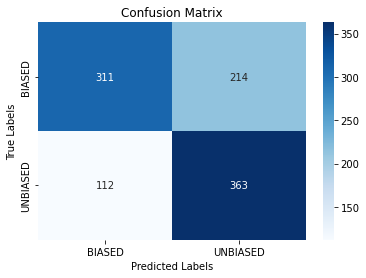

In [59]:
# Evaluation Function

def evaluate(model, test_loader, threshold=0.5):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for data in test_loader:           
            labels = data['targets'].to(device)
            input_ids = data['input_ids'].to(device, dtype=torch.long)
            attention_mask = data['attention_mask'].to(device, dtype=torch.long)

            feats = featurizer.featurize_batch(
                        data['input_ids'].detach().cpu().numpy(), 
                        data['rel_ids'].detach().cpu().numpy(), 
                        data['pos_ids'].detach().cpu().numpy(), 
                        padded_len=data['input_ids'].shape[1])

            feats = torch.tensor(feats.reshape(feats.shape[0],-1)).to(device, dtype = torch.float)
            
            output = model(feats, input_ids, attention_mask)
            output = torch.sigmoid(output).cpu().detach().numpy().tolist()
            output = np.round(output)
            y_pred.extend(output.tolist())
            y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print('remember: 1 = BIASED, 0 = UNBIASED')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['BIASED', 'UNBIASED'])
    ax.yaxis.set_ticklabels(['BIASED', 'UNBIASED'])
    
    
best_model = Mixed_Model_3().to(device)
optimizer = optim.Adam(best_model.parameters(), lr=1e-5)

destination_folder = "/content/drive/MyDrive/Colab Notebooks/Amplifi Project/Saved Models and Checkpoints"
load_checkpoint(destination_folder + '/mixed_model_3_' + dataset + '.pt', best_model, optimizer)
evaluate(best_model, test_loader)